# lets make a noise generator

In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import math
import random
import numpy as np

In [2]:
# image size
w = 300
h = 300
image = Image.new('RGB', (w, h))

# base grid size
bw = 30
bh = 30

In [3]:
def lerp(a, b, t):
    return a * (1 - t) + b * t

def smooth_noise(a, b, t, remap):
    tt = remap(t)
    return lerp(a, b, tt)

In [43]:
def normalize(noise):
    result = []
    norm = 0
    min = 9999
    max = -100
    for y in range(len(noise)):
        for x in range(len(noise[0])):
            val = noise[y][x]
            if val > max:
                max = val
            if val < min:
                min = val
    
    for y in range(len(noise)):
        row = []
        for x in range(len(noise[0])):
            val = noise[y][x]
            normed = ((val-min)/(max-min))
            row.append(normed)
        result.append(row)
    return result


## Value noise

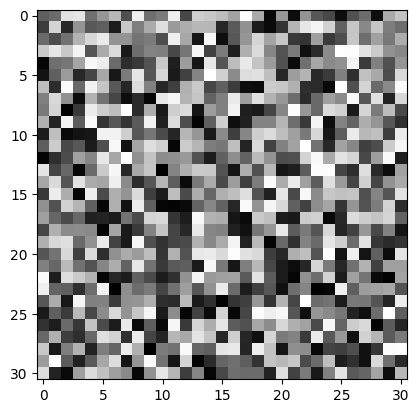

In [4]:
def generate_value_noise_grid():
    base_grid = []
    for _ in range(bh+1):
        xx = []
        for _ in range(bw+1):
            xx.append(random.random())
        base_grid.append(xx)

    return base_grid

value_noise_grid = generate_value_noise_grid()
base_image = Image.new('RGB', (bw+1, bh+1))
base_pixels = base_image.load()
for y in range(bh+1):
    for x in range(bw+1):
        val = int(value_noise_grid[y][x]*255)
        base_pixels[x, y] = (val, val, val)

plt.imshow(base_image);
plt.show()


In [5]:
basic = lambda t: t
cosine = lambda t: (1 - math.cos(t * math.pi)) * 0.5
smooth_step = lambda t: t * t * (3 - 2 * t)
advanced = lambda t: 6*t**5-15*t**4+10*t**3

def value_noise(base_pixels, func):
    noise = []
    for y in range(h):
        ty = int(y/h*bh)
        dy = y - ty*(h/bh)
        dy = dy/(h/bh)
        xx = []
        for x in range(w):
            tx = int(x/w*bw)
            c_tl = base_pixels[ty, tx][0]
            c_tr = base_pixels[ty, tx+1][0]
            c_bl = base_pixels[ty+1, tx][0]
            c_br = base_pixels[ty+1, tx+1][0]

            dx = x - tx*(w/bw)
            dx = dx/(w/bw)

            c_top = smooth_noise(c_tl, c_tr, dx, func)
            c_bot = smooth_noise(c_bl, c_br, dx, func)

            val = smooth_noise(c_top, c_bot, dy, func)

            xx.append(val/255)
        noise.append(xx)
    return noise

noise = value_noise(base_pixels, cosine)


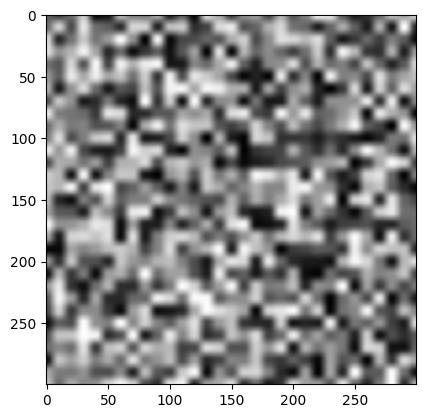

In [6]:
pixels = image.load()
for y in range(h):
    for x in range(w):
        val = noise[y][x]
        val = int(val*255)
        pixels[x, y] = (val, val, val)

plt.imshow(image);
plt.show()

## Gradient noise

In [7]:
def generate_gradient_noise_grid(base_w, base_h):
    base_grid = []
    for _ in range(base_h+1):
        xx = []
        for _ in range(base_w+1):
            r = 1
            a = random.random() * 2 * math.pi
            x = r * math.cos(a)
            y = r * math.sin(a)
            xx.append(np.array([x, y]))
        base_grid.append(xx)
    return base_grid


In [17]:
def gradient_noise(gradient_noise_grid, w, h, base_w, base_h, func):
    noise = []
    for y in range(h):
        ty = int(y/h*base_h)
        th = int(h/base_h)
        ty_y = int(ty*th)
        dy = y - ty*(h/base_h)
        dy = dy/(h/base_h)
        xx = []
        for x in range(w):
            tx = int(x/w*base_w)
            tw = int(w/base_w)
            tx_x = int(tx*tw)
                        
            dp_tl = (gradient_noise_grid[ty][tx]) @ (np.array([(tx_x-x)/2, (ty_y-y)/2]))
            dp_tr = (gradient_noise_grid[ty][tx+1]) @ (np.array([((tx_x+tw)-x)/2, (ty_y-y)/2]))
            dp_bl = (gradient_noise_grid[ty+1][tx]) @ (np.array([(tx_x-x)/2, ((ty_y+th)-y)/2]))
            dp_br = (gradient_noise_grid[ty+1][tx+1]) @ (np.array([((tx_x+tw)-x)/2, ((ty_y+th)-y)/2]))

            dx = x - tx*(w/base_w)
            dx = dx/(w/base_w)

            c_top = smooth_noise(dp_tl, dp_tr, dx, func)
            c_bot = smooth_noise(dp_bl, dp_br, dx, func)

            val = ((smooth_noise(c_top, c_bot, dy, func)+5)/9)
            xx.append(val)
        noise.append(xx)
    return normalize(noise)

In [18]:
def perlin_noise(w, h, base_w, base_h):
    grid = generate_gradient_noise_grid(base_w, base_h)
    return  gradient_noise(grid, w, h, base_w, base_h, advanced)

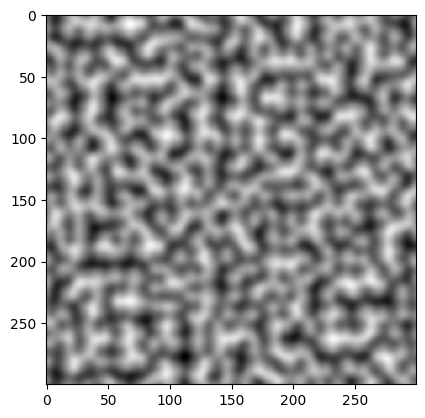

In [60]:
# generate perlin noise image

noise = perlin_noise(300, 300, 20, 20)

img_test = Image.new('RGB', (300, 300))
img_test_pixels = img_test.load()
for y in range(h):
    for x in range(w):
        val = int((noise[y][x])*255)
        img_test_pixels[x, y] = (val, val, val)

plt.imshow(img_test)
plt.show()

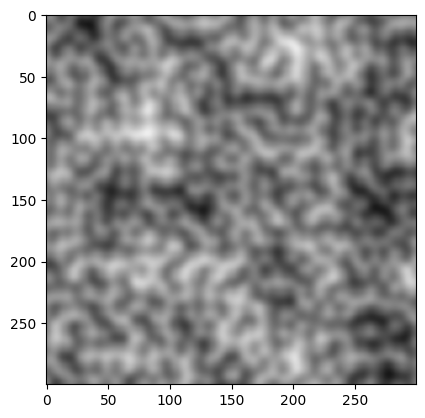

In [61]:
# generate perlin noise sum image

noise_0 = perlin_noise(300, 300, 5, 5)
noise_1 = perlin_noise(300, 300, 20, 20)

img_test = Image.new('RGB', (300, 300))
img_test_pixels = img_test.load()
for y in range(h):
    for x in range(w):
        val = int(((noise_0[y][x]+noise_1[y][x])/2)*255)
        img_test_pixels[x, y] = (val, val, val)

plt.imshow(img_test)
plt.show()